この Notebook は、コンペでデータを解析して最初の prediction を作成するまでの形式化を目的とするものです。  
Kaggle で行われている Titanic コンペを例として説明します。  
  
コンペページ：  
- https://www.kaggle.com/c/titanic
  
以下の Kernel を参考にさせてもらいました。  
- https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy  
- https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83  


# Step1: ライブラリロード
必要なライブラリをロードします。

In [1]:
import sys
print("Python version: {}". format(sys.version))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython.display import display
print("IPython version: {}". format(IPython.__version__)) 

import sklearn
print("scikit-learn version: {}". format(sklearn.__version__))

import keras
print("keras version: {}". format(keras.__version__))

import random
import time

import warnings
warnings.filterwarnings('ignore')

Python version: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
pandas version: 0.24.2
matplotlib version: 3.0.3
NumPy version: 1.16.3
SciPy version: 1.2.1
IPython version: 7.5.0
scikit-learn version: 0.20.3


Using TensorFlow backend.


keras version: 2.2.4


In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from keras import models, layers

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# Step2: データロード
データをロードし、pandas の info(), sample(), describe() を使って各カラムの情報などをざっと確認します。

In [3]:
train_org = pd.read_csv('./input/train.csv')
test_org  = pd.read_csv('./input/test.csv')

print (train_org.info())
display(train_org.sample(10))
train_org.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
723,724,0,2,"Hodges, Mr. Henry Price",male,50.0,0,0,250643,13.0000,NaN,S
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
809,810,1,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,1,0,113806,53.1000,E8,S
603,604,0,3,"Torber, Mr. Ernst William",male,44.0,0,0,364511,8.0500,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
818,819,0,3,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
404,405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,NaN,S
857,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
834,835,0,3,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Step3: EDA (Explanatory Data Analysis: 探索的データ解析)
前処理や特徴生成のためにデータを解析します。  

## 何を行うか
このステップで下記のような点を確認していきます。

1. 各カラムについて下記を確認
    - ユニークな値の数
    - 欠損値の確認

1. カテゴリーデータについて下記を確認
    - 各値ごとの目的変数の平均

1. 数値データについて下記を確認
    - 分布
    - 外れ値

1. その他、テキストデータなどから何かしら情報が取れないかを確認


## Titanic データからわかること
このステップによって、Titanic データの以下のような特徴があることがわかるようになります。

- 各カラムの種類
    - PassengerId: 識別子
    - Pclass, Sex: カテゴリーデータ
    - Age, SibSp, Parch, Fare: 数値データ
    - Name, Ticket, Cabin: テキストかつユニークな値の数が多いためそのままでは特徴量にしづらい

- 欠損値が含まれるカラム
    - Age
    - Cabin
    - Embarked
    - Fare

- 外れ値、異常値の有無
    - 明らかな外れ値、異常値はないように見える
    - ただし、Fare は、中央値 14 に対して、最大値 512 と非対称な分布なので注意が必要

- 個別のカラムについて
    - Name から敬称が取れる
        - 敬称には、性別や既婚かどうかなどの情報が含まれており、役に立つ可能性がある
        - ただし、Major, Capt, Don などあまり含まれない敬称がノイズとなる可能性がある
    - Ticket から家族を判別できる可能性がある
    - Cabin から船内の階層を特定できる


In [4]:
# ユニークな値の確認

def count_unique_values(df):
    for name, col in df.iteritems():
        if col.dtype != 'float64':
            print('{} unique values: {}'.format(name, col.nunique()))
        else:
            print('{} is float'.format(name))

print('Train unique values:')
count_unique_values(train_org.drop('Survived', axis=1))
print("-"*10)
print('Test unique values:')
count_unique_values(test_org)

Train unique values:
PassengerId unique values: 891
Pclass unique values: 3
Name unique values: 891
Sex unique values: 2
Age is float
SibSp unique values: 7
Parch unique values: 7
Ticket unique values: 681
Fare is float
Cabin unique values: 147
Embarked unique values: 3
----------
Test unique values:
PassengerId unique values: 418
Pclass unique values: 3
Name unique values: 418
Sex unique values: 2
Age is float
SibSp unique values: 7
Parch unique values: 8
Ticket unique values: 363
Fare is float
Cabin unique values: 76
Embarked unique values: 3


In [5]:
# 欠損値の確認

print('Train null values:')
print(train_org.isnull().sum())
print("-"*10)
print('Test null values:')
print(test_org.isnull().sum())

Train null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test null values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# カテゴリー、数値(整数)データからの大体の傾向をつかむ

for name, col in train_org.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1).iteritems():
    if col.dtype != 'float64':
        print('Survival Correlation by:', name)
        print(train_org[[name, 'Survived']].groupby(name, as_index=False).mean())
        print('-'*10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
---------- 



Text(0.5, 1.0, 'Fare Boxplot')

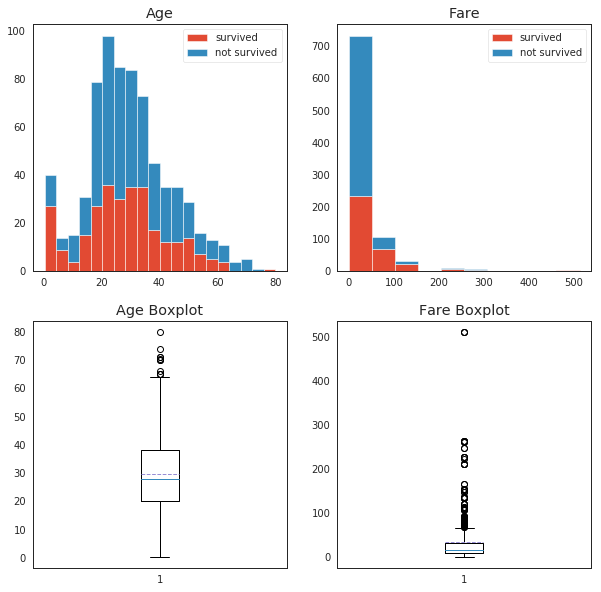

In [7]:
# 数値(実数)データからの傾向をつかむ

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

survived = train_org[train_org['Survived']==1]
not_survived = train_org[train_org['Survived']==0]

axes[0][0].hist([survived['Age'].dropna(), not_survived['Age'].dropna()], label=['survived', 'not survived'], stacked=True, bins=20)
axes[0][0].set_title('Age')
axes[0][0].legend()
axes[0][1].hist([survived['Fare'], not_survived['Fare']], label=['survived', 'not survived'], stacked=True)
axes[0][1].set_title('Fare')
axes[0][1].legend()

axes[1][0].boxplot(train_org['Age'].dropna(), showmeans = True, meanline = True)
axes[1][0].set_title('Age Boxplot')
axes[1][1].boxplot(train_org['Fare'], showmeans = True, meanline = True)
axes[1][1].set_title('Fare Boxplot')

下記の点が読み取れる
- Age, Fare ともに目的変数に寄与しそうなこと
- Fare は情報側に尾の長い分布となっている

In [8]:
# Name についての解析

data = pd.concat([train_org, test_org])
data.head(20)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


名前から敬称が取れる

In [9]:
# Name から敬称を取得

title = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Sir               1
the Countess      1
Capt              1
Mme               1
Don               1
Dona              1
Lady              1
Jonkheer          1
Name: 0, dtype: int64

In [10]:
# Ticket についての解析
# ユニークな値の確認をしたことによって、ほぼレコードごとにユニークだが重複した値があることがわかっている
# 重複の多いチケット上位5つのレコードを確認する
groupsizes = data.groupby('Ticket').size()
dup_tickets = groupsizes[groupsizes > 1].sort_values(ascending=False).head(5).index
data[data['Ticket'].isin(dup_tickets)].sort_values('Ticket')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
692,NaN,NaN,S,56.4958,"Lam, Mr. Ali",0,693,3,male,0,1.0,1601
74,32.0,NaN,S,56.4958,"Bing, Mr. Lee",0,75,3,male,0,1.0,1601
39,NaN,NaN,S,56.4958,"Hee, Mr. Ling",0,931,3,male,0,NaN,1601
838,32.0,NaN,S,56.4958,"Chip, Mr. Chang",0,839,3,male,0,1.0,1601
169,28.0,NaN,S,56.4958,"Ling, Mr. Lee",0,170,3,male,0,0.0,1601
826,NaN,NaN,S,56.4958,"Lam, Mr. Len",0,827,3,male,0,0.0,1601
643,NaN,NaN,S,56.4958,"Foo, Mr. Choong",0,644,3,male,0,1.0,1601
509,26.0,NaN,S,56.4958,"Lang, Mr. Fang",0,510,3,male,0,1.0,1601
140,10.0,NaN,S,46.9000,"Goodwin, Miss. Jessie Allis",2,1032,3,female,5,NaN,CA 2144
139,40.0,NaN,S,46.9000,"Goodwin, Mr. Charles Frederick",6,1031,3,male,1,NaN,CA 2144


同一 last name の家族であることがわかる  
同一チケットの場合、Embarked, Fare, Pclass も同じである傾向がある

In [11]:
# Cabin についての解析

data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

アルファベットと数字からなる  
アルファベットは船内の階層を表しているらしい  
https://www.kaggle.com/c/titanic/discussion/4693

# Step4: 前処理 & 特徴量生成
前ステップからわかっている結果を使って、前処理と特徴生成を行っていきます。

## 何を行うか
このステップで下記のようなことを行っていきます。
1. 異常値、外れ値の修正
1. 欠損値の補完  
1. EDA 結果からの特徴量生成  
1. カテゴリーエンコード  
1. スケール変換 (正規化、標準化)

以下、それぞれの項目についての補足です。

**2. 欠損値の補完**：  
基本的に、数値であれば中央値か平均。カテゴリーであれば最頻値で埋めるのが良いかと思います。

**3. EDA 結果からの特徴量生成**：  
前ステップの EDA 結果を使って特徴量を作っていきます。
特徴量は多すぎてもあまり良いことはないですが、私はこの段階ではあまり気にせず思いついたものを全部作ってしまうようにしています。  
その上で、後のステップで特徴量選択をして、有用な特徴量のみを残すようにしています。

**4. カテゴリーエンコード**：  
この段階では、カテゴリーの値の種類が多くても対応できる mean encoding、Label encoding を使うことが多いです。  
One-Hot encoding の場合、特徴量がどのくらい結果に寄与したかが解釈しづらくなってしまうため、この段階ではあまり使いません。  
また、ユニークな値の数が多い場合は、頻度の低いカテゴリーをまとめてしまうなどを行っておく。  


## Titanic データに固有な特徴量生成
基本的には上記のステップに沿って処理を行っていきますが、EDA の結果から Titanic データに特有な以下の特徴量を生成しています。
- Title：Name から敬称を抜き出した値
- Family_Survival：Name, Ticket などを使って同一家族内での生存者数を推測した値
- FareBin：Fare を離散化した値
- CabinLayer：Cabin から船内の階層を抜き出した値

In [12]:
train = train_org.copy()
test = test_org.copy()

In [13]:
# 異常値、外れ値の修正

# Titanic データでは特に対応はしない


In [14]:
# 欠損値の補完

def fillna(df, col_name, value):
    df[col_name].fillna(value, inplace = True)

# Age
median_age = train['Age'].median()
fillna(train, 'Age', median_age)
fillna(test, 'Age', median_age)

# Embarked
mode_emb = train['Embarked'].mode()[0]
fillna(train, 'Embarked', mode_emb)
fillna(test, 'Embarked', mode_emb)

# Fare
median_fare = train['Fare'].median()
fillna(train, 'Fare', median_fare)
fillna(test, 'Fare', median_fare)

# Cabin
fillna(train, 'Cabin', 'UNK')
fillna(test, 'Cabin', 'UNK')

In [15]:
# 特徴生成

for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0

    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    df['CabinLayer'] = df['Cabin'].apply(lambda x: x if x == 'UNK' else x[0])


data = train.append(test)
n_train = len(train)

# 数が少ない Title を Misc として扱う
title_counts = data['Title'].value_counts()
few_titles = title_counts[title_counts < 10].index
train.loc[train['Title'].isin(few_titles), 'Title'] = 'Misc'
test.loc[test['Title'].isin(few_titles), 'Title'] = 'Misc'

# FareBin 分布が非対称であるため qcut を使う
data['FareBin'] = pd.qcut(data['Fare'], 5)
train['FareBin'] = data['FareBin'][:n_train]
test['FareBin'] = data['FareBin'][n_train:]

# AgeBin
data['AgeBin'] = pd.cut(data['Age'], 5)
train['AgeBin'] = data['AgeBin'][:n_train]
test['AgeBin'] = data['AgeBin'][n_train:]

In [16]:
# 特徴生成 (生存家族数)

data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
data['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data.loc[data['Family_Survival']!=0.5].shape[0])

for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data[data['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train['Family_Survival'] = data['Family_Survival'][:891]
test['Family_Survival'] = data['Family_Survival'][891:]

Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


In [17]:
# カテゴリーエンコード

data = train.append(test)
target_cols = ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin', 'CabinLayer']
encoders = {}

for col in target_cols:
    encoders[col] = LabelEncoder().fit(data[col])
    
for df in [train, test]:
    for col, enc in encoders.items():
        df['{}_Code'.format(col)] = enc.transform(df[col])
        

# mean-eocoding
def mean_encoding(train, test, category_name, mean_target_name):
    data = train.append(test)
    group = train.groupby([category_name]).agg({mean_target_name: ['mean']})
    column_name = '{}_mean_{}'.format(category_name, mean_target_name)
    group.columns = [column_name]
    group.reset_index(inplace=True)

    df = pd.merge(data, group, on=[category_name], how='left')
    
    n_train = len(train)
    train[column_name] = df[column_name][:n_train].values
    test[column_name] = df[column_name][n_train:].values
    test[column_name].fillna(df[column_name].mean(), inplace = True)

col_names = ['Pclass', 'AgeBin_Code', 'FareBin_Code', 'CabinLayer_Code', 'Title_Code', 'Embarked_Code', 'Sex_Code']
for col in col_names:
    mean_encoding(train, test, col, 'Survived')

In [18]:
# Scaling と仕上げ

# 不要な列の削除
drop_cols = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'CabinLayer', 'FareBin', 'AgeBin']
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

# 説明変数と目的変数への分離
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test
col_names = X_train.columns

# スケール変換
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

In [19]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Family_Survival,Title_Code,...,AgeBin_Code,Embarked_Code,Sex_Code,Pclass_mean_Survived,AgeBin_Code_mean_Survived,FareBin_Code_mean_Survived,CabinLayer_Code_mean_Survived,Title_Code_mean_Survived,Embarked_Code_mean_Survived,Sex_Code_mean_Survived
0,0,3,22.0,1,0,7.2500,2,0,0.5,3,...,1,2,1,0.242363,0.344168,0.217877,0.299854,0.156673,0.339009,0.188908
1,1,1,38.0,1,0,71.2833,2,0,0.5,4,...,2,0,0,0.629630,0.404255,0.645349,0.593220,0.792000,0.553571,0.742038
2,1,3,26.0,0,0,7.9250,1,1,0.5,2,...,1,2,0,0.242363,0.344168,0.201087,0.299854,0.697802,0.339009,0.742038
3,1,1,35.0,1,0,53.1000,2,0,0.0,4,...,2,2,0,0.629630,0.404255,0.645349,0.593220,0.792000,0.339009,0.742038
4,0,3,35.0,0,0,8.0500,1,1,0.5,3,...,2,2,1,0.242363,0.404255,0.201087,0.299854,0.156673,0.339009,0.188908


In [20]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Family_Survival,Title_Code,FareBin_Code,...,AgeBin_Code,Embarked_Code,Sex_Code,Pclass_mean_Survived,AgeBin_Code_mean_Survived,FareBin_Code_mean_Survived,CabinLayer_Code_mean_Survived,Title_Code_mean_Survived,Embarked_Code_mean_Survived,Sex_Code_mean_Survived
0,3,34.5,0,0,7.8292,1,1,0.5,3,0,...,2,1,1,0.242363,0.404255,0.217877,0.299854,0.156673,0.389610,0.188908
1,3,47.0,1,0,7.0000,2,0,0.5,4,0,...,2,2,0,0.242363,0.404255,0.217877,0.299854,0.792000,0.339009,0.742038
2,2,62.0,0,0,9.6875,1,1,0.5,3,1,...,3,1,1,0.472826,0.434783,0.201087,0.299854,0.156673,0.389610,0.188908
3,3,27.0,0,0,8.6625,1,1,0.5,3,1,...,1,2,1,0.242363,0.344168,0.201087,0.299854,0.156673,0.339009,0.188908
4,3,22.0,1,1,12.2875,3,0,1.0,4,2,...,1,2,0,0.242363,0.344168,0.426901,0.299854,0.792000,0.339009,0.742038


# Step5: 特徴量選択
重要そうな feature にあたりをつけます。

## 何を行うか
下記を参考に、重要な特徴量を選択します。
- RandomForest の feature_importances_
- RFE (Recursive Feature Elimination; 再帰的特徴量削減)


## Titanic データで有用な特徴量
このステップの結果から下記のカラムが有用そうであることがわかります。
- Age：年齢
- Fare：料金
- Family_Survival：生存した家族数
- CabinLayer_Code：客室の階層をラベルエンコードした値
- Title_Code_mean_Survived：敬称を mean エンコードした値
- Pclass_mean_Survived：Pclass を mean エンコードした値
- Sex_Code_mean_Survived：性別を mean エンコードした値

Text(0.5, 0, 'Feature importance')

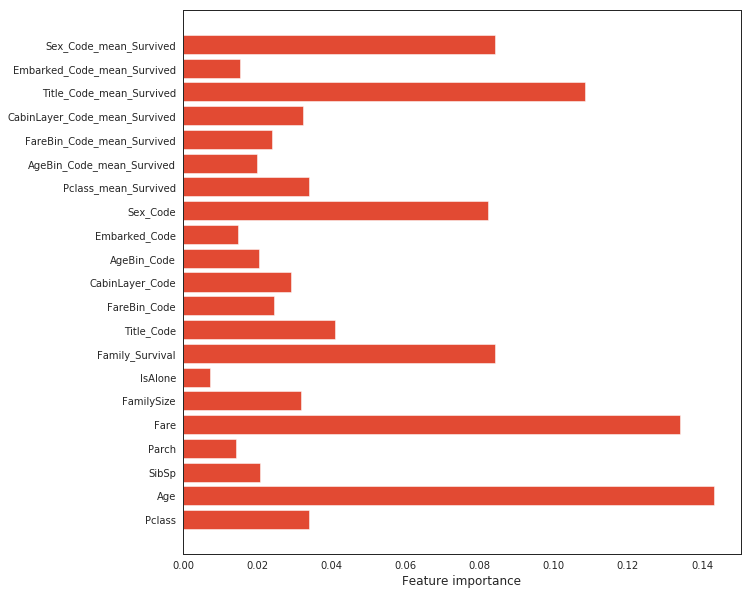

In [21]:
# RandomForest の feature_importances_ による特徴量選択

forest = ensemble.RandomForestClassifier(n_estimators=1000, random_state=0)
forest.fit(X_train, y_train)

n_features = X_train.shape[1]
plt.figure(figsize=(10, 10))
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), train.drop('Survived', axis=1).columns)
plt.xlabel('Feature importance')

In [22]:
# RFE による特徴量選択

def select_feature(dtree, cv_split, output=True):
    # すべての特徴量を使用した結果
    base_results = model_selection.cross_validate(dtree, X_train, y_train, cv  = cv_split)
    dtree.fit(X_train, y_train)

    if (output):
        print('BEFORE DT Parameters: ', dtree.get_params())
        print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
        print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
        print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
        print('-'*10)

        print('BEFORE DT RFE Training Shape Old: ', X_train.shape) 
        print('BEFORE DT RFE Training Columns Old: ', X_train.columns.values)

        print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
        print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
        print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
        print('-'*10)


    # 選択された特徴量のみを使用した結果
    dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
    dtree_rfe.fit(X_train, y_train)

    X_rfe = X_train.columns.values[dtree_rfe.get_support()]
    rfe_results = model_selection.cross_validate(dtree, X_train, y_train, cv  = cv_split)

    if (output):
        print('AFTER DT RFE Training Shape New: ', X_train[X_rfe].shape) 
        print('AFTER DT RFE Training Columns New: ', X_rfe)

        print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
        print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
        print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
        print('-'*10)
    
    return X_rfe
    
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )
dtree = tree.DecisionTreeClassifier(random_state = 0)
select_feature(dtree, cv_split)

BEFORE DT Parameters:  {'max_depth': None, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best', 'random_state': 0, 'criterion': 'gini', 'max_features': None, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_impurity_split': None, 'min_samples_leaf': 1, 'presort': False, 'min_samples_split': 2, 'class_weight': None}
BEFORE DT Training w/bin score mean: 98.86
BEFORE DT Test w/bin score mean: 79.03
BEFORE DT Test w/bin score 3*std: +/- 5.50
----------
BEFORE DT RFE Training Shape Old:  (891, 21)
BEFORE DT RFE Training Columns Old:  ['Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'FamilySize' 'IsAlone'
 'Family_Survival' 'Title_Code' 'FareBin_Code' 'CabinLayer_Code'
 'AgeBin_Code' 'Embarked_Code' 'Sex_Code' 'Pclass_mean_Survived'
 'AgeBin_Code_mean_Survived' 'FareBin_Code_mean_Survived'
 'CabinLayer_Code_mean_Survived' 'Title_Code_mean_Survived'
 'Embarked_Code_mean_Survived' 'Sex_Code_mean_Survived']
BEFORE DT RFE Training w/bin score mean: 98.86
BEFORE DT RFE Test w/bin score mean: 79.0

array(['Pclass', 'Age', 'Parch', 'Fare', 'Family_Survival',
       'CabinLayer_Code', 'Sex_Code', 'Title_Code_mean_Survived'],
      dtype=object)

結果は出ているが、かなり過学習傾向が強いので結果として採用しない

In [23]:
# RFE による特徴量選択
# 過学習傾向が強いため、モデルのパラメーターで制御する

dtree = tree.DecisionTreeClassifier(max_depth=3, random_state=0)
select_feature(dtree, cv_split)

print('='*20)
dtree = tree.DecisionTreeClassifier(max_depth=10, random_state=0)
select_feature(dtree, cv_split)

BEFORE DT Parameters:  {'max_depth': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best', 'random_state': 0, 'criterion': 'gini', 'max_features': None, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_impurity_split': None, 'min_samples_leaf': 1, 'presort': False, 'min_samples_split': 2, 'class_weight': None}
BEFORE DT Training w/bin score mean: 85.69
BEFORE DT Test w/bin score mean: 84.29
BEFORE DT Test w/bin score 3*std: +/- 7.25
----------
BEFORE DT RFE Training Shape Old:  (891, 21)
BEFORE DT RFE Training Columns Old:  ['Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'FamilySize' 'IsAlone'
 'Family_Survival' 'Title_Code' 'FareBin_Code' 'CabinLayer_Code'
 'AgeBin_Code' 'Embarked_Code' 'Sex_Code' 'Pclass_mean_Survived'
 'AgeBin_Code_mean_Survived' 'FareBin_Code_mean_Survived'
 'CabinLayer_Code_mean_Survived' 'Title_Code_mean_Survived'
 'Embarked_Code_mean_Survived' 'Sex_Code_mean_Survived']
BEFORE DT RFE Training w/bin score mean: 85.69
BEFORE DT RFE Test w/bin score mean: 84.29
B

array(['Pclass', 'Age', 'Fare', 'Family_Survival', 'CabinLayer_Code',
       'Title_Code_mean_Survived'], dtype=object)

max_depth=3 では、問題ないが 10 程度では過学習傾向が強くなる

In [24]:
# RFE による特徴量選択
# いくつかのハイパーパラメーターで複数のモデルを作り投票により重要な特徴量を選択する

features = []
for max_depth in [2,4,6,8,10]:
    dtree = tree.DecisionTreeClassifier(max_depth=max_depth, random_state = 0)
    features.extend(select_feature(dtree, cv_split, output=False))
    
features = pd.Series(features)
features.value_counts()

Title_Code_mean_Survived    5
Family_Survival             5
Fare                        4
CabinLayer_Code             4
Age                         4
Pclass_mean_Survived        3
IsAlone                     1
Pclass                      1
FamilySize                  1
Sex_Code                    1
dtype: int64

# Step6: モデルと評価
様々なモデルを評価して、有用なモデルにあたりをつけます。

## 何を行うか
なるべく多様なモデルで、それぞれの性能をとりあえずデフォルトのハイパーパラメーターを使って測定します。  
多様なモデルを使うことが望ましいですが、学習に時間がかかることやハイパーパラメーターに気を使う必要があることから、ニューラルネットは外しています。  
また、(私のスキルでは) ニューラルネットの学習結果を解釈するのが難しく、仮にニューラルネットで高い性能を出したとしてもそこから次の分析に活かしづらいため、この段階では除外しています。  

## Titanic データで有効なモデル
このステップの結果からは下記のモデルが有効そうなことがわかります。
- GaussianProcessClassifier
- SVC
- XGBClassifier

In [25]:
col_names = ['Age', 'Fare', 'Family_Survival', 'CabinLayer_Code',
             'Title_Code_mean_Survived', 'Pclass_mean_Survived', 'Sex_Code_mean_Survived']

X_train = X_train[col_names]
X_test = X_test[col_names]

In [26]:
X_train.head()

,Age,Fare,Family_Survival,CabinLayer_Code,Title_Code_mean_Survived,Pclass_mean_Survived,Sex_Code_mean_Survived
0,-0.565736,-0.502445,-0.060661,0.522067,-0.828375,-0.856082,-0.737695
1,0.663861,0.786845,-0.060661,-1.917594,1.488392,1.487302,1.355574
2,-0.258337,-0.488854,-0.060661,0.522067,1.144893,-0.856082,1.355574
3,0.433312,0.420730,-1.604923,-1.917594,1.488392,1.487302,1.355574
4,0.433312,-0.486337,-0.060661,0.522067,-0.828375,-0.856082,-0.737695


In [27]:
X_test.head()

,Age,Fare,Family_Survival,CabinLayer_Code,Title_Code_mean_Survived,Pclass_mean_Survived,Sex_Code_mean_Survived
0,0.394887,-0.490783,-0.060661,0.522067,-0.828375,-0.856082,-0.737695
1,1.355510,-0.507479,-0.060661,0.522067,1.488392,-0.856082,1.355574
2,2.508257,-0.453367,-0.060661,0.522067,-0.828375,0.538472,-0.737695
3,-0.181487,-0.474005,-0.060661,0.522067,-0.828375,-0.856082,-0.737695
4,-0.565736,-0.401017,1.483600,0.522067,1.488392,-0.856082,1.355574


In [28]:
# 様々なモデルにて学習と予想を実施

MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # xgboost
    XGBClassifier()    
    ]


cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

# それぞれのモデルでのスコアを保持する DataFrame
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# それぞれのモデルでの予想結果を保持する DataFrame
MLA_predict = X_train.copy()

row_index = 0
for alg in MLA:

    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    alg.fit(X_train, y_train)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index+=1

    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
5,GaussianProcessClassifier,"{'kernel': None, 'n_restarts_optimizer': 0, 'm...",0.881835,0.859701,0.0498606,0.190751
14,SVC,"{'kernel': 'rbf', 'gamma': 'auto_deprecated', ...",0.859738,0.858582,0.0468146,0.0317233
21,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 3, 'subsam...",0.900375,0.857836,0.0473469,0.0244875
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.879775,0.854104,0.0460046,0.00154362
6,LogisticRegressionCV,"{'cv': 'warn', 'solver': 'lbfgs', 'penalty': '...",0.85,0.852612,0.043137,0.0545831
8,RidgeClassifierCV,"{'store_cv_values': False, 'cv': None, 'normal...",0.851311,0.852612,0.0439998,0.00303161
19,LinearDiscriminantAnalysis,"{'n_components': None, 'store_covariance': Fal...",0.850562,0.850746,0.0427723,0.00210152
16,LinearSVC,"{'penalty': 'l2', 'intercept_scaling': 1, 'fit...",0.849625,0.850373,0.0470815,0.021659
3,GradientBoostingClassifier,"{'learning_rate': 0.1, 'max_depth': 3, 'subsam...",0.921536,0.849254,0.0251305,0.048585
15,NuSVC,"{'kernel': 'rbf', 'gamma': 'auto_deprecated', ...",0.853184,0.846642,0.0496717,0.0364007


Text(0, 0.5, 'Algorithm')

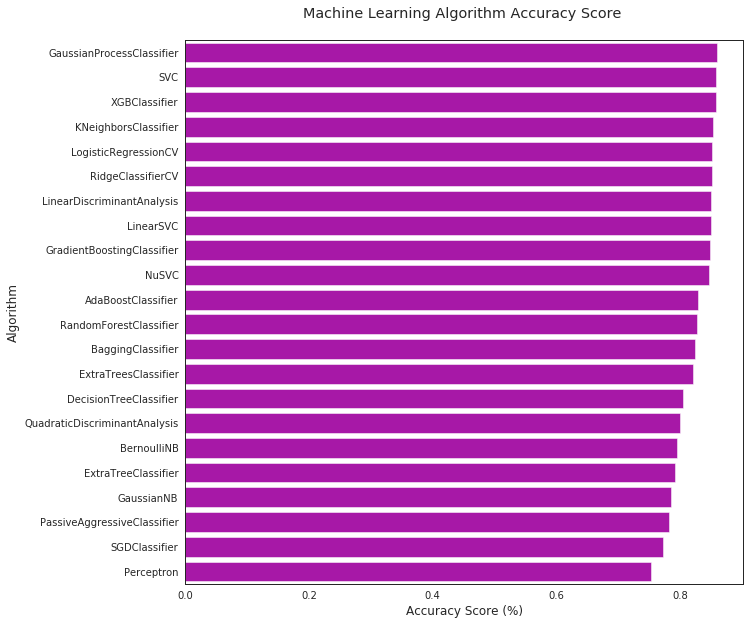

In [29]:
# 各モデルのスコアを可視化

plt.figure(figsize=(10, 10))
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

# Step7: ハイパーパラメーターのチューニング
各モデルに対してハイパーパラメーターのチューニングを行います。

## 何を行うか
Step 6 の結果とモデルの多様性を考慮して最適パラメーターを探索するモデルを決定します。  
それらのモデルに対して最適なパラメーターを求めます。

In [30]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

# 対象のモデル
vote_est = [
    # Ensemble Methods
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    # Gaussian Processes
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    # GLM
    ('lr', linear_model.LogisticRegressionCV()),
    
    # Navies Bayes
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    # Nearest Neighbor
    ('knn', neighbors.KNeighborsClassifier()),
    
    # SVM
    ('svc', svm.SVC(probability=True)),
    
    # xgboost
    ('xgb', XGBClassifier())
]

In [31]:
# ハイパーパラメーターの探索範囲の定義

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            # AdaBoostClassifier
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            # BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            # ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            # GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1
            'n_estimators': [300], #default=100
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            # RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False
            'random_state': grid_seed
             }],
    
            [{    
            # GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            # LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]

In [32]:
# Grid Search による最適パラメーターの探索

start_total = time.perf_counter()
for clf, param in zip (vote_est, grid_param):

    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X_train, y_train)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

The best parameter for AdaBoostClassifier is {'learning_rate': 0.05, 'random_state': 0, 'n_estimators': 300} with a runtime of 25.31 seconds.
The best parameter for BaggingClassifier is {'random_state': 0, 'max_samples': 0.25, 'n_estimators': 300} with a runtime of 22.61 seconds.
The best parameter for ExtraTreesClassifier is {'max_depth': 8, 'random_state': 0, 'criterion': 'gini', 'n_estimators': 100} with a runtime of 43.07 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'random_state': 0, 'n_estimators': 300} with a runtime of 29.84 seconds.
The best parameter for RandomForestClassifier is {'max_depth': 6, 'random_state': 0, 'criterion': 'entropy', 'n_estimators': 100, 'oob_score': True} with a runtime of 53.72 seconds.
The best parameter for GaussianProcessClassifier is {'random_state': 0, 'max_iter_predict': 10} with a runtime of 7.60 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state'

# Step8: アンサンブル
それぞれのモデルの結果をマージし、最終的な prediction を作成します。

## 何を行うか
ニューラルネットによる Stacking によってアンサンブルを行っています。  
データに対する制約が少ないためニューラルネットを使うようにしていますが、決定木ベースの手法のほうが結果の解釈はしやすいので適宜別のモデルを使って見ても良いかと思います。

In [33]:
# 各モデルの prediction 作成

columns = [name for name, _ in vote_est]
train_predictions = pd.DataFrame(columns=columns)
test_predictions = pd.DataFrame(columns=columns)

for clf, param in zip (vote_est, grid_param):
    clf[1].fit(X_train, y_train)
    
    train_predictions[clf[0]] = clf[1].predict(X_train)
    test_predictions[clf[0]] = clf[1].predict(X_test)

In [34]:
# もともとの特徴量をマージする場合は下記を実行
# train_predictions = pd.concat([X_train, train_predictions], axis=1)
# test_predictions = pd.concat([X_test, test_predictions], axis=1)

In [35]:
display(train_predictions.head(20))
display(test_predictions.head(20))

,ada,bc,etc,gbc,rfc,gpc,lr,bnb,gnb,knn,svc,xgb
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1


,ada,bc,etc,gbc,rfc,gpc,lr,bnb,gnb,knn,svc,xgb
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,1,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# Stacking 用モデルの作成

def get_model():
    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape=(len(train_predictions.columns),)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


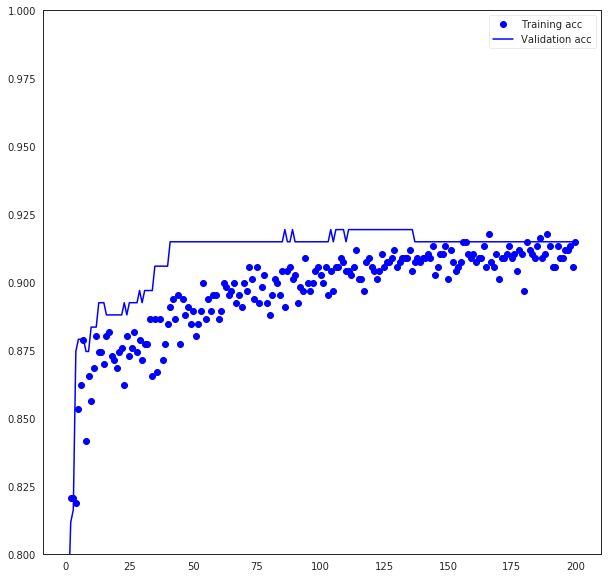

In [37]:
# epochs を決めるための学習

X_sta_train, X_sta_val, y_sta_train, y_sta_val = model_selection.train_test_split(train_predictions, y_train)
model = get_model()
n_epochs = 200
history = model.fit(X_sta_train, y_sta_train, epochs=n_epochs, validation_data=(X_sta_val, y_sta_val), verbose=0)

epochs = range(1, n_epochs + 1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.ylim(0.8, 1.0)
plt.legend()

In [38]:
# 交差検証による精度確認

kf = model_selection.KFold(n_splits=4)
n_epochs = 30

for k, (train_index, val_index) in enumerate(kf.split(train_predictions)):
    X_sta_train = train_predictions.loc[train_index]
    y_sta_train = y_train.loc[train_index]
    X_sta_val = train_predictions.loc[val_index]
    y_sta_val = y_train.loc[val_index]
    
    model = get_model()
    model.fit(X_sta_train, y_sta_train, epochs=n_epochs, verbose=0)
    
    score = model.evaluate(X_sta_val, y_sta_val)
    print('score in fold {}: {}'.format(k, score))

223/223 [==============================] - 0s 149us/step
score in fold 0: [0.3286878733891543, 0.9013452880051104]
223/223 [==============================] - 0s 193us/step
score in fold 1: [0.3158207732198484, 0.901345291747106]
223/223 [==============================] - 0s 251us/step
score in fold 2: [0.3356624536984705, 0.8834080722834498]
222/222 [==============================] - 0s 283us/step
score in fold 3: [0.2684722957578865, 0.923423419664572]


In [39]:
# test セットに対する prediction の作成

model = get_model()
model.fit(train_predictions, y_train, epochs=n_epochs, verbose=0)

y_pred = model.predict_classes(test_predictions)

temp = pd.DataFrame(pd.read_csv("./input/test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("./output/submission.csv", index = False)